# _Randomly Connected Neural Networks for Self-Supervised Monocular Depth Estimation_ Demo Notebook

## Imports

In [1]:
! pip install --upgrade pip
! pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 22.1.2
    Uninstalling pip-22.1.2:
      Successfully uninstalled pip-22.1.2


In [2]:
from matplotlib import pyplot as plt

from PIL import Image

import torch
from torch.nn import BCELoss
from torch.utils.data import DataLoader
from torchvision import transforms

import yaml

from loaders import DaVinciDataset

from model import RandomlyConnectedModel, RandomDiscriminator

import train
from train.loss import GeneratorLoss

## Setup

### CUDA

In [3]:
device = torch.device("cuda") \
    if torch.cuda.is_available() \
        else torch.device("cpu")

print(device)

cuda


### Config file

In [4]:
with open("config.yml") as f:
    model_config = yaml.load(f, Loader=yaml.Loader)

encoder_config = model_config["encoder"]
decoder_config = model_config["decoder"]

### Hyperparameters

In [5]:
# Dataset parameters
batch_size = 8
training_samples = 15000
validation_samples = 1000
numberof_workers = 8

# Training parameters
numberof_epochs = 100
learning_rate = 1e-4

## Dataset

### Transforms

In [6]:
train_transform = transforms.Compose([
    train.transforms.ResizeImage((256, 512)),
    train.transforms.RandomFlip(0.5),
    train.transforms.ToTensor(),
    train.transforms.RandomAugment(0.5, gamma=(0.8, 1.2),
                                   brightness=(0.5, 2.0),
                                   colour=(0.8, 1.2))
])

val_transform = transforms.Compose([
    train.transforms.ResizeImage((256, 512)),
    train.transforms.ToTensor()
])

### CityScapes

In [7]:
train_dataset = DaVinciDataset("../datasets/da-vinci/", "train",
                               train_transform, training_samples)
                                  
val_dataset = DaVinciDataset("../datasets/da-vinci/", "test",
                             val_transform, validation_samples)

print(f"Dataset size:"
      f"\n\tTrain: {len(train_dataset):,} images."
      f"\n\tTest: {len(val_dataset):,} images.")

Dataset size:
	Train: 15,000 images.
	Test: 1,000 images.


### Loaders

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size,
                          shuffle=True, num_workers=numberof_workers)

val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=True, num_workers=numberof_workers)

## Model

### Initialisation

In [9]:
# Temporary solution until config code is set up
model = RandomlyConnectedModel(load_graph="graphs/nodes_5_seed_42").to(device)
disc = None #RandomDiscriminator(load_graph="graphs/nodes_5_seed_42").to(device)

loss_function = GeneratorLoss().to(device)
disc_loss_function = None #BCELoss().to(device)

numberof_parameters = sum(p.numel() for p in model.parameters())
print(f"Model has {numberof_parameters:,} learnable parameters.")
print(f"Using CUDA? {next(model.parameters()).is_cuda}")

Model has 22,818,044 learnable parameters.
Using CUDA? True


### Train

In [10]:
train.train_model(model, train_loader, loss_function, numberof_epochs,
                  learning_rate, disc, disc_loss_function,
                  val_loader=val_loader, evaluate_every=1, 
                  save_path="trained/da-vinci", save_every=1,
                  save_comparison_to="results/da-vinci",
                  device=device)

Epoch #1:   0%|          | 0/1875 [00:00<?, ?batch/s]/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:4215: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
Epoch #18:  68%|██████▊   | 1279/1875 [13:25<06:10,  1.61batch/s, disc=None, model=3.12e+4]

### Evaluate

In [ ]:
model.eval()

loss_function = GeneratorLoss().to(device)

train.evaluate_model(model, val_loader, loss_function,
                     save_comparison_to="results/cityscapes",
                     device=device)

: 

### Results

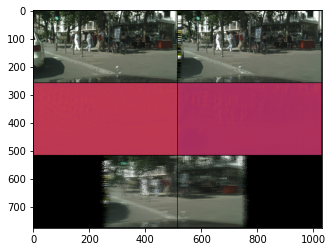

In [ ]:
image = Image.open("results/final.png")
plt.imshow(image)